In [1]:
# Code from 
import torch
import math

dtype = torch.float
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

# Create Tensors to hold input and outputs.
# By default, requires_grad=False, which indicates that we do not need to
# compute gradients with respect to these Tensors during the backward pass.
x = torch.linspace(-math.pi, math.pi, 2000, dtype=dtype)
y = torch.sin(x)

# Create random Tensors for weights. For a third order polynomial, we need
# 4 weights: y = a + b x + c x^2 + d x^3
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
a = torch.randn((), dtype=dtype, requires_grad=True)
b = torch.randn((), dtype=dtype, requires_grad=True)
c = torch.randn((), dtype=dtype, requires_grad=True)
d = torch.randn((), dtype=dtype, requires_grad=True)

learning_rate = 1e-6
for t in range(2000):
    # Forward pass: compute predicted y using operations on Tensors.
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute and print loss using operations on Tensors.
    # Now loss is a Tensor of shape (1,)
    # loss.item() gets the scalar value held in the loss.
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item())

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    loss.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # Manually zero the gradients after updating weights
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')

/home/jessica/miniconda3/envs/torch-test/lib/python3.12/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


99 6375.8388671875
199 4491.802734375
299 3166.23828125
399 2233.270751953125
499 1576.4093017578125
599 1113.79833984375
699 787.8978271484375
799 558.2427368164062
899 396.368408203125
999 282.24127197265625
1099 201.75924682617188
1199 144.99136352539062
1299 104.94190216064453
1399 76.68191528320312
1499 56.7372932434082
1599 42.65882873535156
1699 32.71961212158203
1799 25.70155143737793
1899 20.745460510253906
1999 17.245044708251953
Result: y = -0.09607917070388794 + 0.8433883786201477 x + 0.016575252637267113 x^2 + -0.09143111109733582 x^3


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("stock-data.csv")
df.info()
df.drop("Date", inplace=True, axis = 1)
df = df.replace(",","", regex = True)
df = df.astype(float)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    990 non-null    object 
 1   Open    990 non-null    float64
 2   High    990 non-null    float64
 3   Low     990 non-null    float64
 4   Close   990 non-null    float64
dtypes: float64(4), object(1)
memory usage: 38.8+ KB


In [3]:
data = df[["Close"]]

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
data["Close"] = scaler.fit_transform(data["Close"].values.reshape(-1,1))
print(data.shape)

(990, 1)


/tmp/ipykernel_3619619/2017097845.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Close"] = scaler.fit_transform(data["Close"].values.reshape(-1,1))


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class stockPredictorLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(stockPredictorLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    #goes through each layer of the neural netwrok and returns an answer depending
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

model = stockPredictorLSTM(1,35,3,1)

In [6]:
#split training and validation sets manually
dataset = data.values

test_set_size = int(np.round(0.2*data.shape[0]))
train_set_size = data.shape[0] - test_set_size
print(test_set_size)
print(train_set_size)

train = dataset[0:train_set_size,:]
print(train.shape)

test = dataset[train_set_size:,:]
print(test.shape)

198
792
(792, 1)
(198, 1)


In [7]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = int(np.round(0.25*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 21
x_train, y_train, x_test, y_test = split_data(data, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (727, 20, 1)
y_train.shape =  (727, 1)
x_test.shape =  (242, 20, 1)
y_test.shape =  (242, 1)


In [8]:
x_train_lstm = torch.from_numpy(x_train).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)

x_test_lstm = torch.from_numpy(x_test).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [9]:
print(type(x_train_lstm))

<class 'torch.Tensor'>


In [10]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adamax(model.parameters(), lr = 0.01)

epochs = 600
hist = np.zeros(epochs)
for epoch in range(epochs):
    y_train_pred = model.forward(x_train_lstm)

    loss = criterion(y_train_pred, y_train_lstm)
    if (epoch +1) %100 ==0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
    hist[epoch] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

/home/jessica/miniconda3/envs/torch-test/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 99, Loss: 0.004346807021647692
Epoch 199, Loss: 0.0030267219990491867
Epoch 299, Loss: 0.0020255823619663715
Epoch 399, Loss: 0.0017043468542397022
Epoch 499, Loss: 0.001689838944002986
Epoch 599, Loss: 0.001683707581833005


In [11]:
actuals = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))
preds = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))

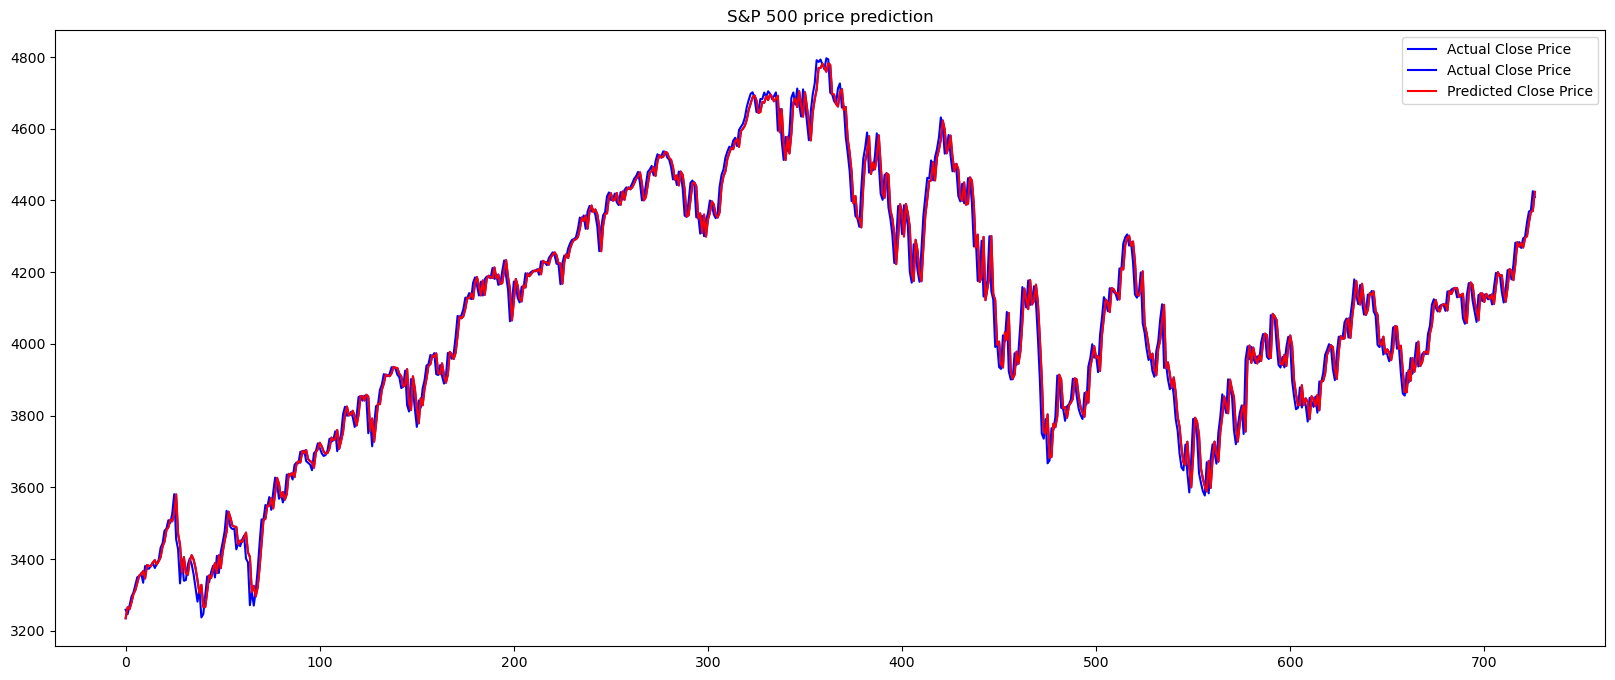

In [12]:
#Plot all predictions
import matplotlib.pyplot as plt

train = data[0:len(actuals)]
valid = actuals
valid['Predictions'] = preds
plt.figure(figsize=(20,8))
plt.plot(valid, color = 'blue', label = 'Actual Close Price')
plt.plot(valid['Predictions'], color = 'red', label = 'Predicted Close Price')
plt.title('S&P 500 price prediction')
plt.legend()
plt.show()

In [13]:
# make predictions
y_test_pred = model(x_test_lstm)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())

y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

          actual    predicted
0    4408.270020  4388.709961
1    4388.140137  4365.689941
2    4367.928711  4381.890137
3    4385.060547  4348.330078
4    4349.178711  4328.820312
..           ...          ...
237  5260.894531  5266.949707
238  5245.051270  5235.479980
239  5224.807617  5277.510254
240  5235.233887  5283.399902
241  5234.669434  5291.339844

[242 rows x 2 columns]


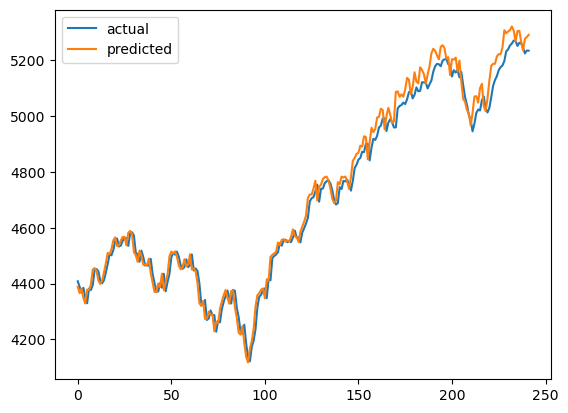

In [14]:
#Shift test predictions for plotting
results_dataframe = pd.concat([pd.DataFrame(y_test_pred), pd.DataFrame(y_test)],axis = 1, ignore_index = True)
results_dataframe.columns =['actual', 'predicted']
print(results_dataframe)

results_dataframe.plot(y=["actual", "predicted"])
plt.show()
